<a href="https://colab.research.google.com/github/hanyuc37/stc510/blob/main/Hanyu_Chen_Text_Analysis_Essential.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from nltk import word_tokenize
from gensim.models import Word2Vec

In [3]:
jeopardy = pd.read_csv("/content/drive/MyDrive/STC 510/Text Analytics/jeopardy_lower.csv")
jeopardy.head()

,Unnamed: 0,category,air_date,question,value,answer,round,show_number
0,0,history,2004-12-31,"'for the last 8 years of his life, galileo was...",$200,copernicus,Jeopardy!,4680
1,1,espn's top 10 all-time athletes,2004-12-31,'no. 2: 1912 olympian; football star at carlis...,$200,jim thorpe,Jeopardy!,4680
2,2,everybody talks about it...,2004-12-31,'the city of yuma in this state has a record a...,$200,arizona,Jeopardy!,4680
3,3,the company line,2004-12-31,"'in 1963, live on ""the art linkletter show"", t...",$200,mcdonald\'s,Jeopardy!,4680
4,4,epitaphs & tributes,2004-12-31,"'signer of the dec. of indep., framer of the c...",$200,john adams,Jeopardy!,4680


In [4]:
jeopardy.head()
jeopardy = jeopardy.drop(columns = 'Unnamed: 0')

In [5]:
import nltk
nltk.download('punkt')
token_questions = [word_tokenize(x) for x in jeopardy['question']]
# Create a column with tokenized questions
jeopardy['token_questions'] = token_questions

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [6]:
import string
from nltk import download
from nltk.corpus import stopwords
download('stopwords')
eng_stopwords = set(stopwords.words('english')+ list(string.punctuation)+['``','...']) #some wired puncts

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
# Remove stopped words and punctuations
for i in range(len(jeopardy['token_questions'])):
  for j in jeopardy['token_questions'][i]:
    if j in eng_stopwords:
      jeopardy['token_questions'][i].remove(j)

In [8]:
# Stemmer
from nltk import PorterStemmer, WordNetLemmatizer
download('wordnet')
stemmer = PorterStemmer()
for i in range(len(jeopardy['token_questions'])):
  for j in jeopardy['token_questions'][i]:
    j = stemmer.stem(j)

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [9]:
jeopardy_c = jeopardy.copy()

In [10]:
# Delete the '$' from values
jeopardy_c['value'].unique()
jeopardy_c['value'] = jeopardy_c['value'].str.replace('$','')
jeopardy_c['value'] = jeopardy_c['value'].str.replace(',','')

<ipython-input-10-703a47bf69de>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  jeopardy_c['value'] = jeopardy_c['value'].str.replace('$','')


600.0


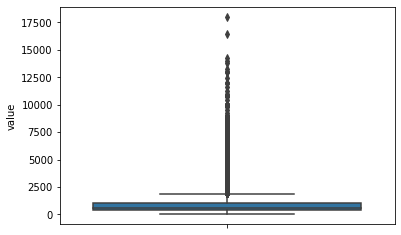

In [11]:
# Convert value to integer
jeopardy_c['value'] = jeopardy_c['value'].astype(int)
# Check the distribution of values
import seaborn as sns
sns.boxplot(y = jeopardy_c['value']) 
# A lot of outliers, use median as the threshold of "high-value" and "low-value"
print(jeopardy_c['value'].median()) # 600
value_p = []
for value in jeopardy_c['value']:
  if value <= 600:
    value_p.append("low value")
  else:
    value_p.append("high value")
jeopardy_c['value_p'] = value_p

In [12]:
# unlist `token_question` column
for i in range(len(jeopardy_c['token_questions'])):
  jeopardy_c['token_questions'][i] = ((((str(jeopardy_c['token_questions'][i]).replace(',','')).replace ('[','')).replace(']','')).replace("'",'')).replace('"','')

<ipython-input-12-8ae660377123>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jeopardy_c['token_questions'][i] = ((((str(jeopardy_c['token_questions'][i]).replace(',','')).replace ('[','')).replace(']','')).replace("'",'')).replace('"','')


In [13]:
jeopardy_c.to_csv("jepardy_new.csv")

In [14]:
jeopardy_c = jeopardy_c[["token_questions","value_p"]]

In [97]:
# Train/Test Split (70%/30%)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier

X_train, X_test, y_train, y_test = train_test_split(jeopardy_c['token_questions'],
                                                   jeopardy_c['value_p'],
                                                   test_size = 0.3,
                                                   random_state = 37)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((149307,), (149307,), (63989,), (63989,))

In [98]:
# Vectoization
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)
X_train

<149307x78255 sparse matrix of type '<class 'numpy.int64'>'
	with 1614198 stored elements in Compressed Sparse Row format>

In [100]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression() 
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)
print("Accuracy:", score)
# With an accuracy of 0.579

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.5786619575239494


In [17]:
# SVM model
from sklearn import svm
classifier = svm.SVC()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)
print("Accuracy:", score)
# accuracy of about 0.599

Accuracy: 0.598806044788948
